### Read data

In [1]:
import sklearn
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from ggplot import *
from gensim.models import Word2Vec, FastText, ldamodel, TfidfModel
import string
from sklearn.manifold import TSNE
import textacy
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
%matplotlib inline

/anaconda3/envs/coms007/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda3/envs/coms007/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
alexa_reviews = pd.read_csv('./amazon_alexa.tsv', sep="\t")

In [3]:
alexa_reviews.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Analysis

In [4]:
# Count Reviews
alexa_reviews.shape

(3150, 5)

In [5]:
# Average Rating
alexa_reviews.rating.mean()

4.463174603174603

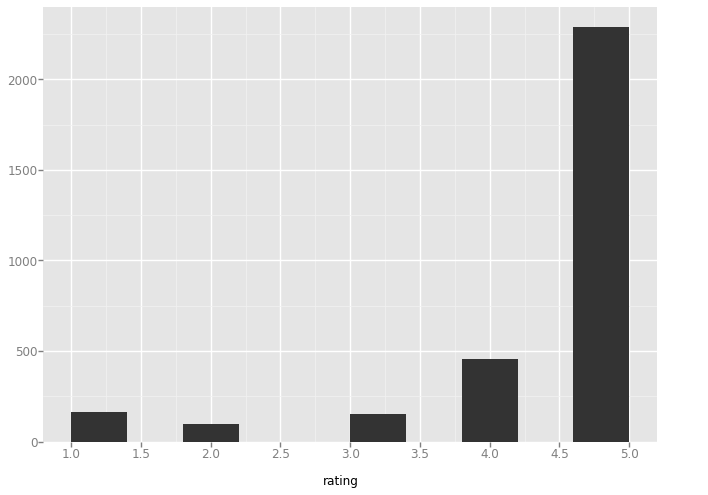

<ggplot: (-9223372029307360796)>

In [6]:
# Histogram of ratings
ggplot(aes(x = 'rating'),data = alexa_reviews) + geom_histogram()

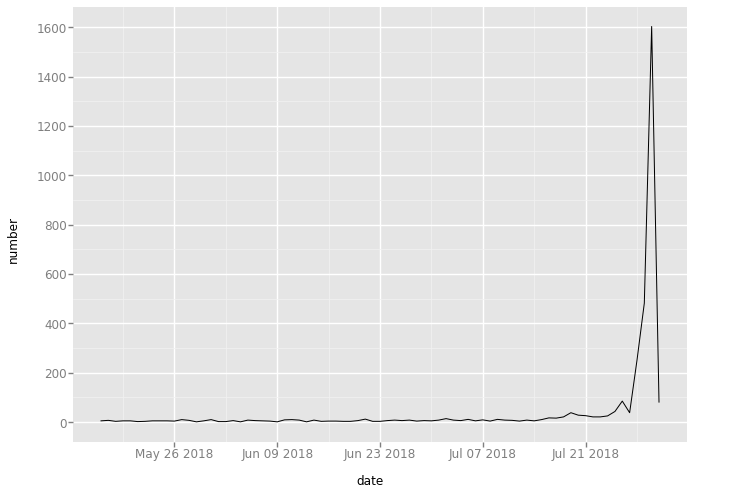

<ggplot: (-9223372029301954893)>

In [7]:
# Time series of reviews
alexa_reviews['date'] = pd.to_datetime(alexa_reviews['date'])
date_counts = pd.DataFrame({'number' : alexa_reviews['date'].value_counts()}).rename_axis('date').reset_index()
ggplot(aes(x = 'date', y = 'number'), data = date_counts) + geom_line() + scale_x_date(labels = date_format("%b %d %Y"))

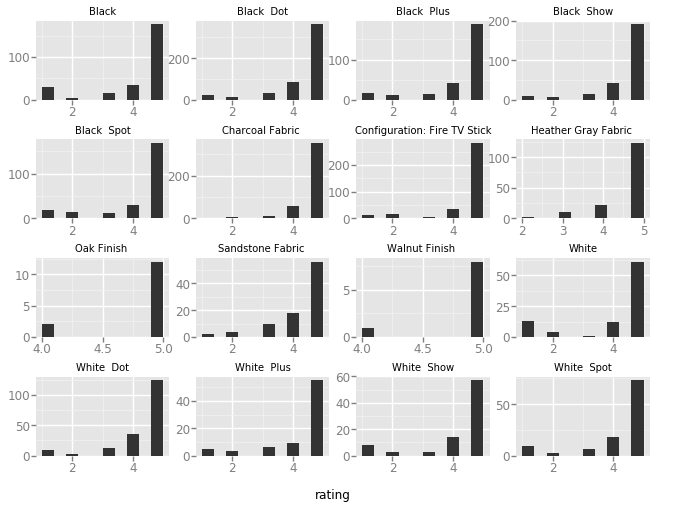

<ggplot: (7552845625)>

In [8]:
# histogram of ratings faceted by color
ggplot(aes(x = 'rating'),data = alexa_reviews) + geom_histogram() + facet_wrap("variation", scales = "free")

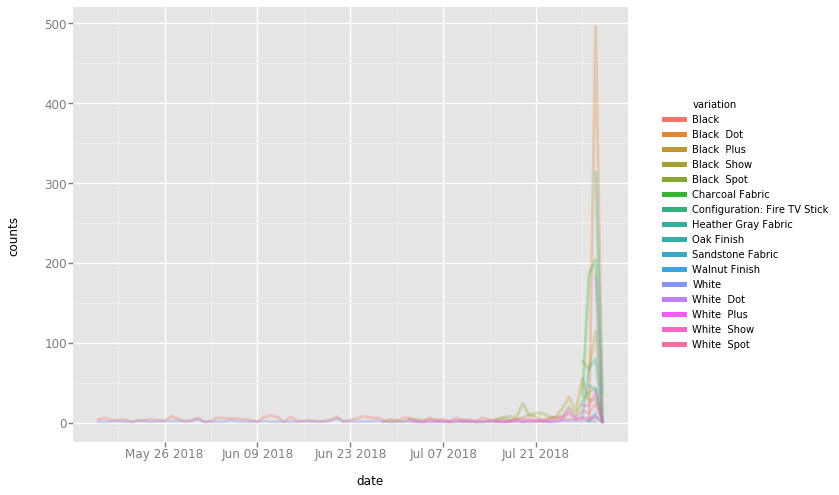

<ggplot: (-9223372029301521229)>

In [9]:
date_color_counts = pd.DataFrame(alexa_reviews.groupby(['date','variation']).size()).reset_index().rename(columns={0:'counts'})
ggplot(aes(x = 'date', y = 'counts', color = "variation"), data = date_color_counts) + geom_line(alpha = 0.3, size = 3) + scale_x_date(labels = date_format("%b %d %Y"))

### Similar Words

In [10]:
## find similar words of all the reviews
sentences = alexa_reviews['verified_reviews'].values
max_sentence_len = 1000

#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
sentences = [" ".join([word for word in doc.split() if word not in stopwords]) for doc in sentences]

# lemmarizer or stemmer
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
# sentences = [' '.join([lemmatizer.lemmatize(word, 'v') for word in doc.split()]) for doc in sentences]
sentences = [' '.join([stemmer.stem(word) for word in doc.split()]) for doc in sentences]

# remove short words
sentences = [' '.join([w for w in doc.split() if len(w)>=3]) for doc in sentences]

sentences = [[word for word in doc.lower().translate(str.maketrans('','',string.punctuation)).split()[:max_sentence_len]] for doc in sentences]

In [11]:
print('Training word2vec...')
time_start = time.time()
word_model = Word2Vec(sentences, size=50, min_count=5, window=5, iter=100, workers = -1)
print('Word2Vec done! Time elapsed: %.3f seconds' %(time.time()-time_start))
pretrained_weights = word_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

Training word2vec...
Word2Vec done! Time elapsed: 0.363 seconds
Result embedding shape: (1124, 50)


In [12]:
for word in ['love', 'echo', 'wife', 'game']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:9])
    print('  %s -> %s' % (word, most_similar))

  love -> featur (0.41), bad (0.38), purchase (0.36), tablet (0.36), dont (0.33), highli (0.32), start (0.31), cover (0.31), feel (0.30)
  echo -> easier (0.44), addit (0.43), device (0.43), advertised (0.39), books (0.38), mother (0.38), longer (0.38), help (0.37), weekend (0.37)
  wife -> 100 (0.39), volume (0.38), eas (0.37), middl (0.37), sooner (0.36), she’ (0.36), quick (0.35), red (0.35), instead (0.35)
  game -> information (0.44), have (0.41), drop (0.39), veri (0.37), arriv (0.36), rang (0.36), future (0.36), understand (0.35), expected (0.35)


In [13]:
# plot similar words
X = word_model[word_model.wv.vocab]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: %.3f seconds' %(time.time()-time_start))

/anaconda3/envs/coms007/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1124 samples in 0.006s...
[t-SNE] Computed neighbors for 1124 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1124
[t-SNE] Computed conditional probabilities for sample 1124 / 1124
[t-SNE] Mean sigma: 0.012951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.998871
[t-SNE] KL divergence after 300 iterations: 2.810174
t-SNE done! Time elapsed: 3.700 seconds


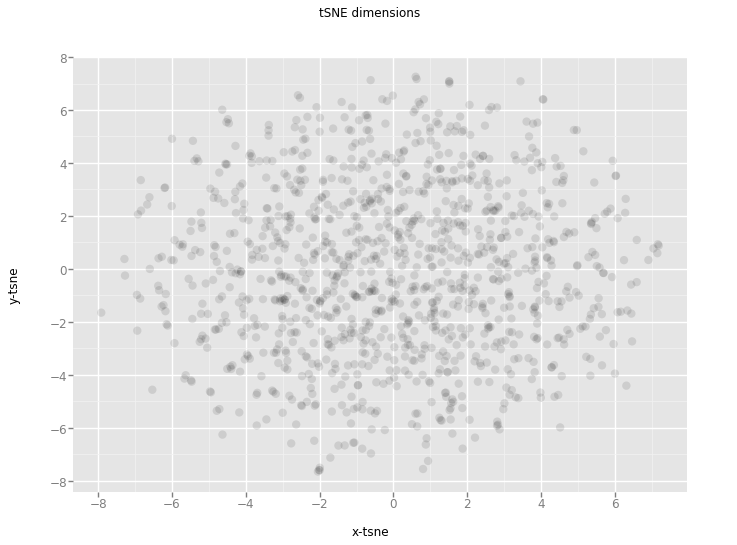

<ggplot: (-9223372029301140192)>

In [14]:
tsne_df = pd.DataFrame()
tsne_df['x-tsne'] = tsne_results[:,0]
tsne_df['y-tsne'] = tsne_results[:,1]
ggplot(tsne_df, aes(x='x-tsne', y='y-tsne')) + geom_point(size=70,alpha=0.1) + ggtitle("tSNE dimensions")

## Named Entity Recognition

In [15]:
import spacy
from spacy import displacy
from collections import Counter
# python -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load()

In [16]:
reviews_appened = ' '.join(alexa_reviews['verified_reviews'])
print('Finding entities...')
time_start = time.time()
doc = nlp(reviews_appened)
print('NER done! Time elapsed: %.3f seconds' %(time.time()-time_start))
print(len(doc.ents))

Finding entities...
NER done! Time elapsed: 24.354 seconds
3666


In [17]:
# top categories
labels = [x.label_ for x in doc.ents]
Counter(labels).most_common(5)

[('ORG', 1254),
 ('CARDINAL', 440),
 ('GPE', 411),
 ('PERSON', 359),
 ('DATE', 313)]

In [18]:
# top tokens
items = [x.text for x in doc.ents]
Counter(items).most_common(5)

[('Alexa', 540), ('Echo', 272), ('Amazon', 160), ('one', 131), (' ', 111)]

In [19]:
data = {
    'text': [X.text for X in doc.ents], 
    'label': [X.label_ for X in doc.ents]}

ner = pd.DataFrame(data = data)
ner = pd.DataFrame(ner.groupby(['text', 'label']).size()).reset_index().rename(columns={0:'counts'}).sort_values('counts', ascending=False)

In [20]:
ner.head()

,text,label,counts
225,Alexa,ORG,539
350,Echo,GPE,265
239,Amazon,ORG,160
872,one,CARDINAL,131
1,,NORP,75


In [21]:
sentences = [x for x in doc.sents]
index = 11
print(sentences[index])
displacy.render(nlp(str(sentences[index])), jupyter=True, style='ent')

I have an iPad but do not see that of any use.  


In [22]:
displacy.render(nlp(str(sentences[index])), style='dep', jupyter = True, options = {'distance': 120})

## Extract facts about Alexa

In [23]:
statements = textacy.extract.semistructured_statements(doc, "Alexa")

# Print the results
print("Here are the top 10 things I know about Alexa:")

for i,statement in enumerate(statements):
    subject, verb, fact = statement
    print(f" - {fact}")
    if i == 10:
        break

Here are the top 10 things I know about Alexa:
 - great all he has to do
 - the one listening to all of his (repeated) stories going forward
 - a great addition to our family
 - great though
 - my new best friend
 - an awesome application to the family
 - way more accurate than I imagined
 - off by as much as 10 degrees
 - great all he has to do
 - the one listening to all of his (repeated) stories going forward
 - a great addition to our family


## Sentiment Analysis

In [24]:
# af = Afinn()
sid = SentimentIntensityAnalyzer()
alexa_reviews['sentiment'] = alexa_reviews.apply(lambda x: sid.polarity_scores(x['verified_reviews'])['compound'], axis = 1)

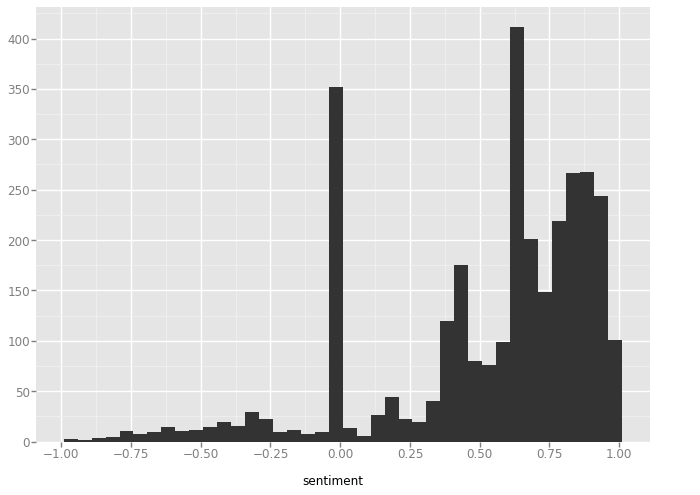

<ggplot: (-9223372029301217122)>

In [25]:
ggplot(aes(x = 'sentiment'),data = alexa_reviews) + geom_histogram(binwidth = 0.05)

## Topic Modelling

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ujjwalpeshin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
## find similar words of all the reviews
sentences = alexa_reviews['verified_reviews'].values
max_sentence_len = 1000

#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
sentences = [" ".join([word for word in doc.split() if word not in stopwords]) for doc in sentences]

# lemmarizer or stemmer
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
# sentences = [' '.join([lemmatizer.lemmatize(word, 'v') for word in doc.split()]) for doc in sentences]
sentences = [' '.join([stemmer.stem(word) for word in doc.split()]) for doc in sentences]

# remove short words
sentences = [' '.join([w for w in doc.split() if len(w)>=3]) for doc in sentences]

sentences = [[word for word in doc.lower().translate(str.maketrans('','',string.punctuation)).split()[:max_sentence_len]] for doc in sentences]

In [28]:
## Using CBOW
# dump dictionary
from gensim import corpora
dictionary = corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(text) for text in sentences]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [29]:
NUM_TOPICS = 5
print('Finding topics...')
time_start = time.time()
lda_model = ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
print('LDA done! Time elapsed: %.3f seconds' %(time.time()-time_start))
lda_model.save('model5_cbow.gensim')
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

Finding topics...
LDA done! Time elapsed: 19.401 seconds
(0, '0.055*"great" + 0.040*"use" + 0.040*"work" + 0.037*"love"')
(1, '0.060*"love" + 0.040*"echo" + 0.026*"dot" + 0.023*"new"')
(2, '0.021*"echo" + 0.015*"like" + 0.013*"the" + 0.013*"alexa"')
(3, '0.020*"echo" + 0.015*"work" + 0.010*"devic" + 0.010*"firestick"')
(4, '0.026*"love" + 0.021*"music" + 0.020*"alexa" + 0.016*"play"')


In [31]:
## Using TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [32]:
NUM_TOPICS = 5
print('Finding topics...')
time_start = time.time()
lda_model = ldamodel.LdaModel(corpus_tfidf, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
print('LDA done! Time elapsed: %.3f seconds' %(time.time()-time_start))
lda_model.save('model5_tfidf.gensim')
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

Finding topics...
LDA done! Time elapsed: 19.579 seconds
(0, '0.043*"great" + 0.027*"product" + 0.026*"work" + 0.011*"fun"')
(1, '0.008*"learn" + 0.008*"use" + 0.008*"awesom" + 0.007*"setup"')
(2, '0.028*"love" + 0.017*"it" + 0.011*"echo" + 0.009*"like"')
(3, '0.030*"easi" + 0.024*"set" + 0.012*"use" + 0.012*"up"')
(4, '0.012*"good" + 0.009*"stick" + 0.008*"fire" + 0.008*"nice"')


## Visualizing Topics

In [33]:
import pyLDAvis
import pyLDAvis.gensim

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = ldamodel.LdaModel.load('model5_cbow.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)